In [ ]:
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d 'masoudnickparvar/brain-tumor-mri-dataset'

 89% 132M/149M [00:00<00:00, 220MB/s]
100% 149M/149M [00:00<00:00, 209MB/s]


In [ ]:
!unzip /content/brain-tumor-mri-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import os
import seaborn as sns
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, Reshape, Input, Conv2DTranspose
from keras.layers import Activation, LeakyReLU, BatchNormalization, Dropout, Resizing
from keras.losses import BinaryCrossentropy
from keras.applications import VGG16

import warnings
warnings.filterwarnings('ignore')

from keras.optimizers import legacy


In [ ]:
NOISE_DIM = 100
BATCH_SIZE = 32
STEPS_PER_EPOCH = 500
EPOCHS = 10
SEED = 40
WIDTH, HEIGHT, CHANNELS = 128, 128, 1
IDX_glioma = 300

OPTIMIZER = legacy.Adam(0.0002, 0.5)

In [ ]:
DIR_1 = "/content/Training/glioma"
DIR_2 = "/content/Training/meningioma"
DIR_3 = "/content/Training/notumor"
DIR_4 = "/content/Training/pituitary"

In [ ]:
def load_images(folder):
    imgs = []
    target = 1
    labels = []
    for i in os.listdir(folder):
        img_dir = os.path.join(folder,i)
        try:
            img = cv2.imread(img_dir)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (128,128))
            imgs.append(img)
            labels.append(target)
        except:
            continue

    imgs = np.array(imgs)
    labels = np.array(labels)

    return imgs, labels

In [ ]:
g_data, g_labels = load_images(DIR_1)
g_data.shape, g_labels.shape

((1321, 128, 128), (1321,))

In [ ]:
np.random.seed(SEED)
idxs = np.random.randint(0, 1321, IDX_glioma)

In [ ]:
X_train_g = g_data[idxs]
X_train_g.shape

(300, 128, 128)

In [ ]:
# Normalize the Images
X_train_g = (X_train_g.astype(np.float32) - 127.5) / 127.5

# Reshape images
X_train_g = X_train_g.reshape(-1, WIDTH,HEIGHT,CHANNELS)

# Check shape
X_train_g.shape

(300, 128, 128, 1)

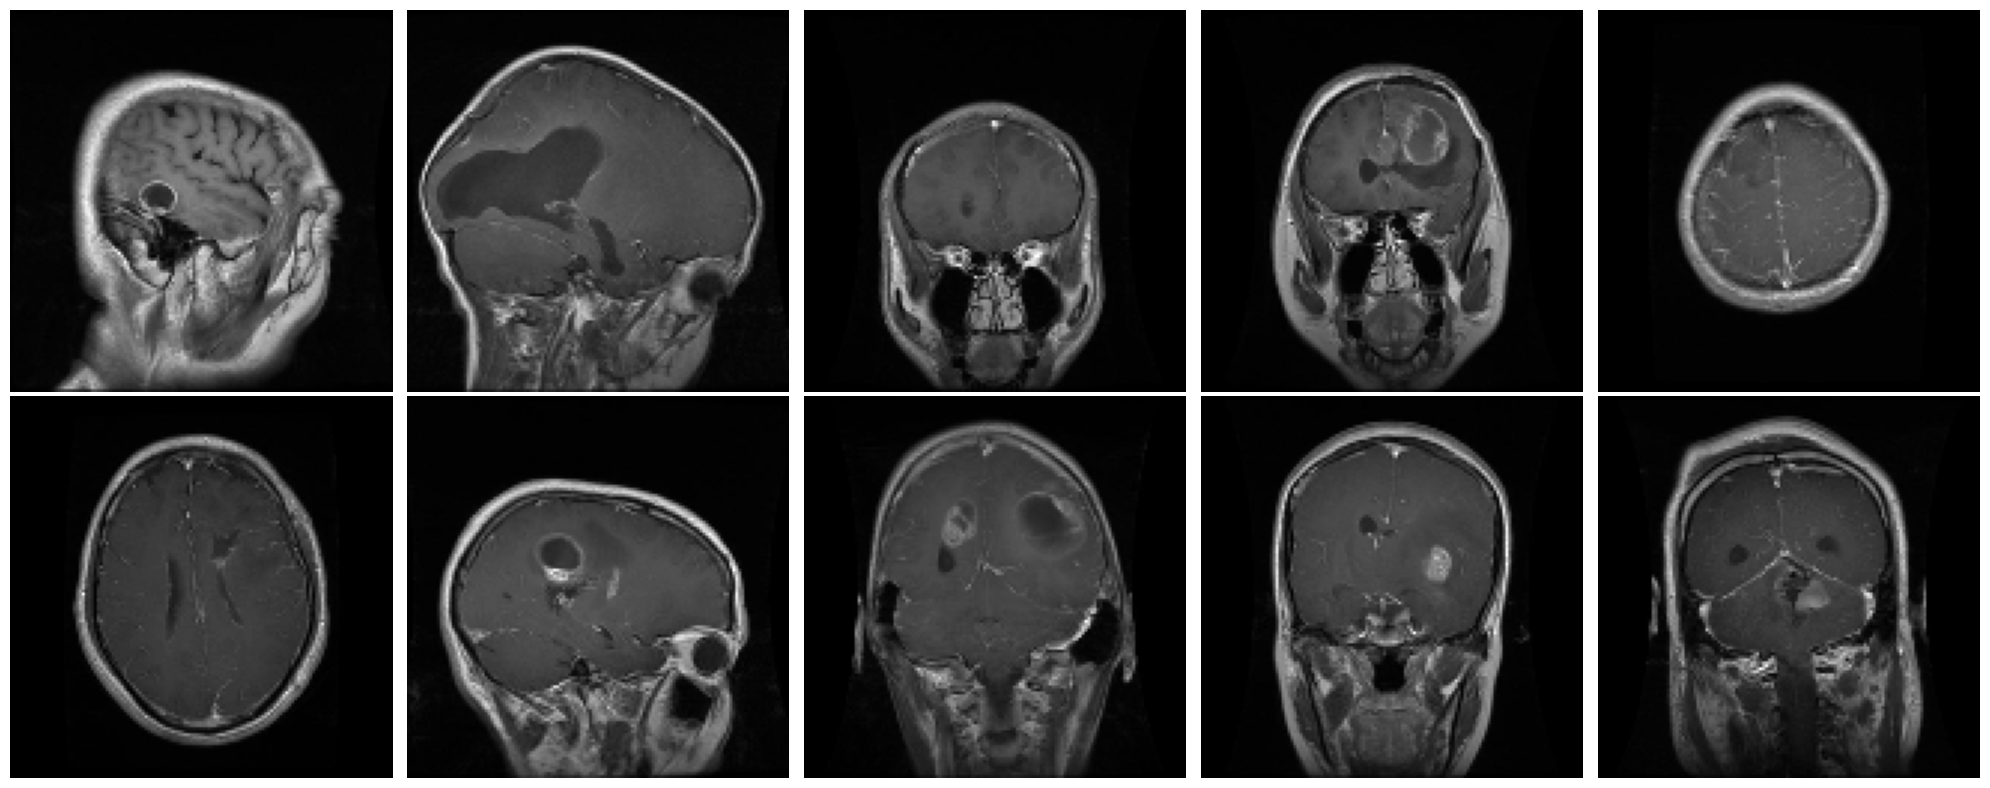

In [ ]:
plt.figure(figsize=(20,8))
for i in range(10):
    axs = plt.subplot(2,5,i+1)
    plt.imshow(X_train_g[i], cmap="gray")
    plt.axis('off')
    axs.set_xticklabels([])
    axs.set_yticklabels([])
    plt.subplots_adjust(wspace=None, hspace=None)
plt.tight_layout()

In [ ]:
def build_generator():

    model = Sequential([

        Dense(32*32*256, input_dim=NOISE_DIM),
        LeakyReLU(alpha=0.2),
        Reshape((32,32,256)),

        Conv2DTranspose(128, (4, 4), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2DTranspose(128, (4, 4), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2D(CHANNELS, (4, 4), padding='same', activation='tanh')
    ],
    name="generator")
    model.summary()
    model.compile(loss="binary_crossentropy", optimizer=OPTIMIZER)

    return model

In [ ]:
def build_discriminator():

    model = Sequential([

        Conv2D(64, (3, 3), padding='same', input_shape=(WIDTH, HEIGHT, CHANNELS)),
        LeakyReLU(alpha=0.2),

        Conv2D(128, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2D(128, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2D(256, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Flatten(),
        Dropout(0.4),
        Dense(1, activation="sigmoid", input_shape=(WIDTH, HEIGHT, CHANNELS))
    ], name="discriminator")
    model.summary()
    model.compile(loss="binary_crossentropy",
                        optimizer=OPTIMIZER)

    return model

In [ ]:
print('\n')
discriminator = build_discriminator()
print('\n')
generator = build_generator()

discriminator.trainable = False

gan_input = Input(shape=(NOISE_DIM,))
fake_image = generator(gan_input)

gan_output = discriminator(fake_image)

gan = Model(gan_input, gan_output, name="gan_model")
gan.compile(loss="binary_crossentropy", optimizer=OPTIMIZER)

print("The Combined Network:\n")
gan.summary()



Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 256)   

In [ ]:
def sample_images(noise, subplots, figsize=(22,8), save=False):
    generated_images = generator.predict(noise)
    plt.figure(figsize=figsize)

    for i, image in enumerate(generated_images):
        plt.subplot(subplots[0], subplots[1], i+1)
        if CHANNELS == 1:
            plt.imshow(image.reshape((WIDTH, HEIGHT)), cmap='gray')

        else:
            plt.imshow(image.reshape((WIDTH, HEIGHT, CHANNELS)))
        if save == True:
            img_name = "gen" + str(i)
            plt.savefig(img_name)
        plt.subplots_adjust(wspace=None, hspace=None)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
#the glioma dataset training#
np.random.seed(SEED)
for epoch in range(EPOCHS):
    for batch in tqdm(range(STEPS_PER_EPOCH)):

        noise = np.random.normal(0,1, size=(BATCH_SIZE, NOISE_DIM))
        fake_X = generator.predict(noise)

        idx = np.random.randint(0, X_train_g.shape[0], size=BATCH_SIZE)
        real_X = X_train_g[idx]

        X = np.concatenate((real_X, fake_X))

        disc_y = np.zeros(2*BATCH_SIZE)
        disc_y[:BATCH_SIZE] = 1

        d_loss = discriminator.train_on_batch(X, disc_y)

        y_gen = np.ones(BATCH_SIZE)
        g_loss = gan.train_on_batch(noise, y_gen)

    print(f"EPOCH: {epoch + 1} Generator Loss: {g_loss:.4f} Discriminator Loss: {d_loss:.4f}")
    noise = np.random.normal(0, 1, size=(10,NOISE_DIM))
    sample_images(noise, (2,5))

In [ ]:
noise = np.random.normal(0, 1, size=(100, NOISE_DIM))
sample_images(noise, (10,10), (24,20), save=True)

In [ ]:
generated_images_glioma = generator.predict(noise)
generated_images_glioma.shape

4/4 [==============================] - 0s 21ms/step


(100, 128, 128, 1)

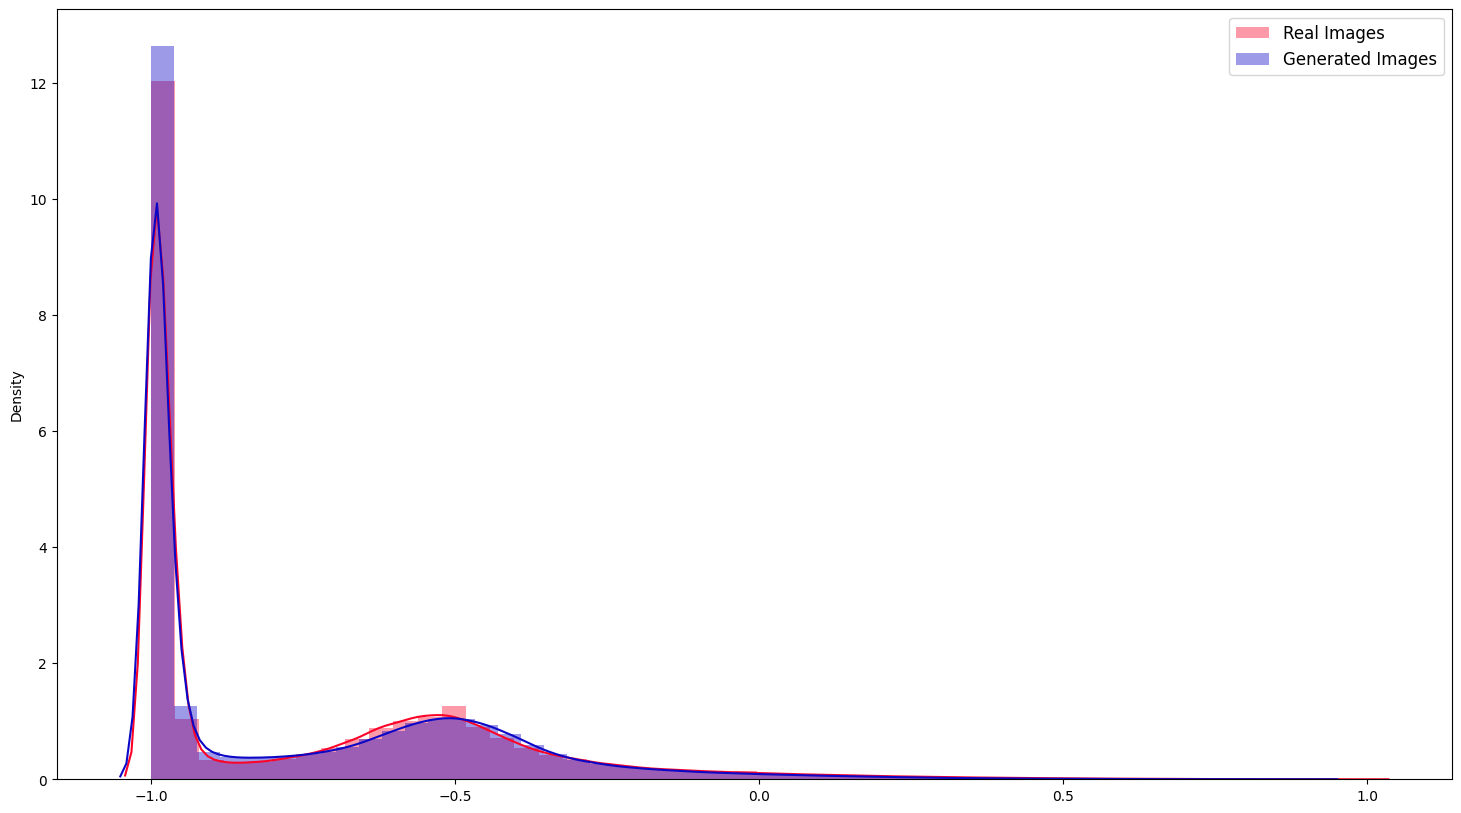

In [ ]:
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(18,10))

sns.distplot(X_train_g, label='Real Images', hist=True, color='#fc0328', ax=axs)
sns.distplot(generated_images_glioma, label='Generated Images', hist=True, color='#0c06c7', ax=axs)

axs.legend(loc='upper right', prop={'size': 12})

plt.show()

**FID SCORE**

In [ ]:
from keras.applications import VGG16
from keras.applications.inception_v3 import InceptionV3,preprocess_input
from scipy.linalg import sqrtm
from scipy import linalg
from keras import backend as K

In [ ]:
model = InceptionV3(include_top=False, pooling='avg', weights=None, input_shape=(128, 128, 3))
def calculate_fid(real_images, generated_images):
    """Calculates the FID score between two arrays of real and generated images."""

    # Add an extra dimension to the input data
    real_images = np.expand_dims(real_images, axis=3)
    generated_images = np.expand_dims(generated_images, axis=3)

    # Ensure input data has 3 channels
    if real_images.shape[-1] == 1:
        real_images = np.repeat(real_images, 3, axis=-1)
    if generated_images.shape[-1] == 1:
        generated_images = np.repeat(generated_images, 3, axis=-1)

    # Preprocess the images
    real_images = preprocess_input(real_images)
    generated_images = preprocess_input(generated_images)

    # Extract features from the real images
    real_features = model.predict(real_images)

    # Extract features from the generated images
    generated_features = model.predict(generated_images)

    # Calculate the mean and covariance of the real and generated features
    mu_real, sigma_real = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu_generated, sigma_generated = np.mean(generated_features, axis=0), np.cov(generated_features, rowvar=False)

    # Ensure covariance matrices are positive semi-definite
    sigma_real = np.cov(real_features, rowvar=False) + np.eye(sigma_real.shape[0]) * 1e-6
    sigma_generated = np.cov(generated_features, rowvar=False) + np.eye(sigma_generated.shape[0]) * 1e-6

    # Calculate the sum squared difference between means
    ssd = np.sum((mu_real - mu_generated)**2.0)

    # Calculate the square root of the product of the covariance matrices
    covmean = sqrtm(sigma_real.dot(sigma_generated))

    # Calculate the FID score
    fid = ssd + np.trace(sigma_real + sigma_generated - 2.0 * covmean)

    return fid





In [ ]:
batch_size = generated_images_glioma.size // (128 * 128)
generated_images_glioma = generated_images_glioma.reshape(batch_size, 128, 128)
X_train_g = X_train_g.reshape(X_train_g.shape[0], 128, 128)

# Calculate the FID score
print(calculate_fid(X_train_g,generated_images_glioma))

4/4 [==============================] - 0s 14ms/step
1.126579230836637e-15


**INCEPTION SCORE**

In [ ]:
from scipy.stats import entropy
from keras.models import Model


In [ ]:

# Load the pre-trained Inception V3 base model
base_model = InceptionV3(include_top=False, pooling='avg', input_shape=(128, 128, 3))

# Add a classification head to the base model
x = base_model.output
x = Dense(1000, activation='softmax', name='predictions')(x)
inception_model = Model(inputs=base_model.input, outputs=x)

In [ ]:

def calculate_inception_score_for_images(predictions):
    """Calculates the Inception Score for a set of images."""
    scores = []
    for prediction in predictions:
        # Calculate the marginal probability distribution
        marginal_prob = np.mean(prediction, axis=0)

        # Calculate the conditional probability distribution
        conditional_prob = prediction / np.sum(prediction, axis=0, keepdims=True)

        # Add a small constant to prevent numerical instabilities
        conditional_prob = np.clip(conditional_prob, 1e-8, 1.0)

        # Calculate the entropy of the marginal probability distribution
        marginal_entropy = entropy(marginal_prob)

        # Calculate the entropy of the conditional probability distribution
        conditional_entropy = np.mean(entropy(conditional_prob, axis=0))

        # Calculate the Inception Score
        score = np.exp(marginal_entropy - conditional_entropy)
        scores.append(score)

    return np.mean(scores)


In [ ]:
def calculate_inception_score(real_images, generated_images):
    """Calculates the Inception Score between two arrays of real and generated images."""

     # Add an extra dimension to the input data
    real_images = np.expand_dims(real_images, axis=3)
    generated_images = np.expand_dims(generated_images, axis=3)

    # Ensure input data has 3 channels
    if real_images.shape[-1] == 1:
        real_images = np.repeat(real_images, 3, axis=-1)
    if generated_images.shape[-1] == 1:
        generated_images = np.repeat(generated_images, 3, axis=-1)

    # Preprocess the images
    real_images = preprocess_input(real_images)
    generated_images = preprocess_input(generated_images)

    # Concatenate the real and generated images
    images = np.concatenate((real_images, generated_images), axis=0)

    # Get the predictions from the Inception model
    predictions = inception_model.predict(images)

    # Split the predictions into real and generated parts
    real_predictions = predictions[:real_images.shape[0]]
    generated_predictions = predictions[real_images.shape[0]:]

    # Calculate the Inception Score for real images
    real_score = calculate_inception_score_for_images(real_predictions)

    # Calculate the Inception Score for generated images
    generated_score = calculate_inception_score_for_images(generated_predictions)

    return real_score, generated_score

In [ ]:
print(X_train_g.shape, generated_images_glioma.shape)
print(calculate_inception_score(X_train_g,generated_images_glioma))

(300, 128, 128) (100, 128, 128)
13/13 [==============================] - 1s 12ms/step
(0.0011443355696337198, 0.0011443353950220524)
